In [1]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow", # OpenAI의 사전 훈련된 가중치를 위해서
        ]
for p in pkgs:
  print(f"{p} 버전: {version(p)}")

matplotlib 버전: 3.10.0
numpy 버전: 2.0.2
tiktoken 버전: 0.12.0
torch 버전: 2.8.0+cu126
tensorflow 버전: 2.19.0


In [2]:
!wget https://bit.ly/3HlFmc8 -O previous_chapters.py

--2025-11-13 06:02:25--  https://bit.ly/3HlFmc8
Resolving bit.ly (bit.ly)... 67.199.248.10, 67.199.248.11
Connecting to bit.ly (bit.ly)|67.199.248.10|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/rickiepark/llm-from-scratch/refs/heads/main/ch05/01_main-chapter-code/previous_chapters.py [following]
--2025-11-13 06:02:25--  https://raw.githubusercontent.com/rickiepark/llm-from-scratch/refs/heads/main/ch05/01_main-chapter-code/previous_chapters.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9905 (9.7K) [text/plain]
Saving to: ‘previous_chapters.py’

previous_chapters.p 100%[===================>]   9.67K  --.-KB/s    in 0.001s  

2025-11-13 06:02:25 (6.89 MB/s) - ‘previous_chapter

In [3]:
import torch
from previous_chapters import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257, # 어휘 사전 크기
    "context_length": 256, # 짧은 문맥 길이 (원본 길이: 1024)
    "emb_dim": 768, # 임베딩 차원
    "n_heads": 12, # 어텐션 헤드 개수
    "n_layers": 12, # 층 개수
    "drop_rate": 0.1, # 드롭아웃 비율
    "qkv_bias": False, # 쿼리-키-값 생성시 편향 사용 여부
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval(); # 추론 시에는 드롭아웃을 비활성화합니다

In [4]:
import tiktoken
from previous_chapters import generate_text_simple

def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0) # 배치 차원을 추가한다.
  return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
  flat = token_ids.squeeze(0) # 배치 차원을 삭제
  return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("출력 테스트:\n", token_ids_to_text(token_ids, tokenizer))

출력 테스트:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [5]:
inputs = torch.tensor([
    [16833, 3626, 6100], # "every effort moves",
    [40, 1107, 588],  # "I really like"
])

targets = torch.tensor([
    [3626, 6100, 345], # "effort moves you"
    [1107, 588, 11311], # "really like chocolate"
])

In [6]:
with torch.no_grad():
  logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # 어휘 사전의 각 토큰에 대한 확률
print(probas.shape) # 크기: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


In [7]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("토큰 ID:\n", token_ids)

토큰 ID:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [8]:
print(f"첫 번째 샘플의 타깃: {token_ids_to_text(targets[0], tokenizer)}")
print(f"첫 번째 샘플의 타깃: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

첫 번째 샘플의 타깃:  effort moves you
첫 번째 샘플의 타깃:  Armed heNetflix


In [9]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]] # [2, 3, 50257]
print("텍스트 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("텍스트 2:", target_probas_2)

텍스트 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
텍스트 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [10]:
# 토큰 확률의 로그를 계산
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [11]:
# 각 토큰에 대한 평균 확률을 계산
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


In [12]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


In [13]:
# 로짓의 크기는 (batch_size, num_tokens, vocab_size)
print("로짓 크기:", logits.shape)

# 타긱의 크기는 (batch_size, num_tokens)
print("타깃 크기:", targets.shape)

로짓 크기: torch.Size([2, 3, 50257])
타깃 크기: torch.Size([2, 3])


In [14]:
logits_flat= logits.flatten(0, 1)
targets_flat = targets.flatten()

print("펼친 로짓:", logits_flat.shape)
print("펼친 타깃:", targets_flat.shape)

펼친 로짓: torch.Size([6, 50257])
펼친 타깃: torch.Size([6])


In [15]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


In [16]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


In [17]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
  with urllib.request.urlopen(url) as response:
    text_data = response.read().decode('utf-8')
  with open(file_path, "w", encoding="utf-8") as file:
    file.write(text_data)
else:
  with open(file_path, "r", encoding="utf-8") as file:
    text_data = file_read()

In [18]:
# 처음 99개 문자
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [19]:
# 마지막 99개 문자
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [20]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("문자:", total_characters)
print("토큰:", total_tokens)

문자: 20479
토큰: 5145


In [21]:
from previous_chapters import create_dataloader_v1

# 훈련 세트 비율
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [22]:
# 유효성 검사
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
  print("훈련 데이터 로더에 토큰이 충분하지 않습니다."
  "`GPT_CONFIG_124M['context_length']`를 낮추거나 "
  "`train_ratio`를 증가시키세요.")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
  print("훈련 데이터 로더에 토큰이 충분하지 않습니다."
  "`GPT_CONFIG_124M['context_length']`를 낮추거나 "
  "`train_ratio`를 증가시키세요.")

In [23]:
print("훈련 데이터 로더:")
for x, y in train_loader:
  print(x.shape, y.shape)

print("\n검증 데이터 로더:")
for x, y in val_loader:
  print(x.shape, y.shape)

훈련 데이터 로더:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

검증 데이터 로더:
torch.Size([2, 256]) torch.Size([2, 256])


In [24]:
train_tokens = 0
for input_batch, target_batch in train_loader:
  train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
  val_tokens += input_batch.numel()

print("훈련 토큰 수:", train_tokens)
print("검증 토큰 수:", val_tokens)
print("모든 토큰 수:", train_tokens + val_tokens)

훈련 토큰 수: 4608
검증 토큰 수: 512
모든 토큰 수: 5120


In [25]:
def calc_loss_batch(input_batch, target_batch, model, device):
  input_batch, target_batch = input_batch.to(device), target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
  return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
  total_loss = 0.
  if len(data_loader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    # num_batches가 데이터 로더에 있는 배치 개수보다 크면
    # 배치 횟수를 데이터 로더에 있는 총 배치 개수로 맞춘다.
    num_batches = min(num_batches, len(data_loader))
  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      total_loss += loss.item()
    else:
      break
  return total_loss / num_batches

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 노트:
# 애플 실리콘 칩에서 코드를 실행하는 경우 다음 주석을 해제하세요.
# (M3 맥북 에어에서 측정하면) 애플 CPU보다 약 2배 빠릅니다. 하지만 손실 값은 조금 다를 수 있습니다.

if torch.cuda.is_available():
  device = torch.device("cuda")
elif torch.backends.mps.is_available():
  device = torch.device("mps")
else:
  device = torch.device("cpu")
print(f"Using {device} device.")

model.to(device) # nn.Module 클래스의 경우 model = model.to(device)로 할당할 필요가 없다.

torch.manual_seed(123) # 데이터 로더에서 셔플링이 일어나므로 재현가능성을 위해 설정

with torch.no_grad(): # 모델을 아직 훈련하지 않으므로 효율성을 위해 그레이던트 추적을 끈다.
  train_loss = calc_loss_loader(train_loader, model, device)
  val_loss = calc_loss_loader(val_loader, model, device)

print("훈련 손실:", train_loss)
print("검증 손실:", val_loss)

Using cpu device.
훈련 손실: 10.98758347829183
검증 손실: 10.98110580444336


In [32]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
  # 손실과 지금까지 처리한 토큰 수를 추적하기 위해 리스트를 초기화
  train_losses, val_losses, track_tokens_seen = [], [], []
  tokens_seen, global_step = 0, -1

  # 메인 훈련 루프를 시작합니다
  for epoch in range(num_epochs):
    model.train() # 모델을 훈련 모드로 설정n

    for input_batch, target_batch in train_loader:
      optimizer.zero_grad() # 이전 배치 반복에서 얻은 손실의 그레이디언트를 초기화
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      loss.backward() # 손실의 그레이디언트를 계산
      optimizer.step() # 손실의 그레이디언트를 사용하여 모델 가중치를 업데이트 합니다.
      tokens_seen += input_batch.numel()
      global_step += 1

      # 추가적인 평가 단계
      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(
            model, train_loader, val_loader, device, eval_iter
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        print(f"에포크 {epoch+1} (Step {global_step:06d}): "
        f"훈련 소실 {train_loss:.3f}, 검증 손실 {val_loss:.3f}")

    # 각 에포크 후에 샘플 텍스트를 출력합니다.
    generate_and_print_sample(
        model, tokenizer, device, start_context
    )
  return train_losses, val_losses, track_tokens_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
  model.train()
  return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
  model.eval()
  context_size = model.pos_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate_text_simple(
        model=model, idx=encoded,
        max_new_tokens=50, context_size=context_size
    )
  decoded_text = token_ids_to_text(token_ids, tokenizer)
  print(decoded_text.replace("\n", " ")) # 간결한 출력 포맷을 위해
  model.train()

In [33]:
# 노트:
# 실행 시간을 계산하고 싶다면 다음 주석을 해제
# import time
# start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# 노트:
# 실행 시간을 계산하고 싶다면 다음 주석 해제
# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"훈련 소요 시간: {execution_time_minutes:.2f}분.)

에포크 1 (Step 000000): 훈련 소실 9.781, 검증 손실 9.933
에포크 1 (Step 000005): 훈련 소실 8.111, 검증 손실 8.339
Every effort moves you,,,,,,,,,,,,.                                     
에포크 2 (Step 000010): 훈련 소실 6.661, 검증 손실 7.048
에포크 2 (Step 000015): 훈련 소실 5.961, 검증 손실 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
에포크 3 (Step 000020): 훈련 소실 5.726, 검증 손실 6.600
에포크 3 (Step 000025): 훈련 소실 5.201, 검증 손실 6.348
Every effort moves you, and I had been.                                            
에포크 4 (Step 000030): 훈련 소실 4.417, 검증 손실 6.278
에포크 4 (Step 000035): 훈련 소실 4.069, 검증 손실 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
에포크 5 (Step 000040): 훈련 소실 3.732, 검증 손실 6.160
Every effort moves you know it was not that the picture--I had the fact by the last I had been--his, and in the            "Oh, and he said, and d

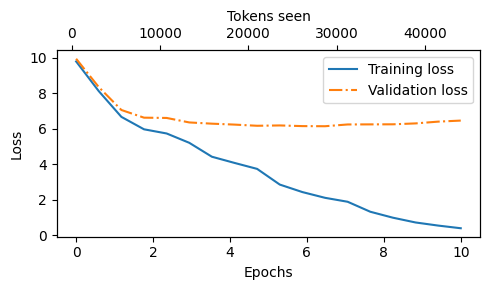

In [36]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
  fig, ax1 = plt.subplots(figsize=(5, 3))

  # 에포크에 대한 훈련 손실과 검증 손실의 그래프를 그린다.
  ax1.plot(epochs_seen, train_losses, label="Training loss")
  ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax1.legend(loc="upper right")
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True)) # only show integer labels on x-axis

  # 처리한 토큰 수에 대한 두 번째 x 축을 만든다.
  ax2 = ax1.twiny() # y 축을 공유하는 두 번째 x 축을 만든다.
  ax2.plot(tokens_seen, train_losses, alpha=0) # 눈금을 정렬하기 위해 투명한 그래프를 만든다.
  ax2.set_xlabel("Tokens seen")

  fig.tight_layout()
  plt.savefig("loss-plot.pdf")
  plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)